# Finnish literature generation using RNN

# Overview



In this experiment I will 
 - Gather a moderate-sized text corpora of Finnish literature from Project Guternberg (some tens of books).
 - Build and train a character-level Recurrent Neural Network (RNN) that will generate text like the Finnish literature used for training the model.
 - Generate some snippets of new Finnish "literature"

Keras & Tensorflow will be used for this task.

For an interesting read of the topic, have a look at the wonderful blog post
 [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).


## Imports

In [1]:
# Selecting Tensorflow version v2 (for Colab only).
# %tensorflow_version 2.x

In [2]:
import platform

import time
import os

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
from collections import Counter

# for downloading the book texts
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse, urljoin
from functools import lru_cache


print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.7.12
Tensorflow version: 2.7.0
Keras version: 2.7.0


In [3]:
# Mount google Drive to Colab (for persisting data and models to colab)
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


## Collect the dataset

Let's grab some Finnish literature text from [Project Gutenberg](https://www.gutenberg.org/browse/languages/fi).

It would probably be best to get all books from same author (or at least similar kinds of books, let's say typical fiction books but not plays that have different style), so that the style is probably more consistent.

I decided to download texts by _Juhani Aho_, who seems to have been a fairly prolific writer.

### Getting works of Juhani Aho from Project Gutenberg

In [4]:
# URL to the list of Finnish books available on Gutenberg
GUTENBERG_FINNISH_CATALOGUE_URL = r"https://www.gutenberg.org/browse/languages/fi"

In [5]:
def get_all_links(url: str) -> list:
  """
  Returns all linked (internal, same site?) URLs that is found on `url`.
  Duplicates are not removed.

  Returns a list of tuples consisting of (link text, url)
  """
  links = []

  soup = BeautifulSoup(requests.get(url).content, "html.parser")

  for a_tag in soup.findAll("a"):
    href = a_tag.attrs.get("href")
    if href == "" or href is None:
        continue
    
    href = urljoin(url, href)

    # remove URL GET parameters, URL fragments, etc.
    parsed_href = urlparse(href)
    href = parsed_href.scheme + "://" + parsed_href.netloc + parsed_href.path
    links.append((a_tag.text, href))

  return links


In [6]:
@lru_cache(200)
def get_book_text(url: str, 
                  suffix: str = ".txt.utf-8",
                  start_labels: list = ["START OF THIS PROJECT GUTENBERG EBOOK", "START OF THE PROJECT GUTENBERG"],
                  end_labels: list = ["End of the Project Gutenberg EBook", "***END OF THE PROJECT GUTENBERG"],
                  chars_to_skip_after_start_label: int = 1500,
                  chars_to_skip_before_end_label: int = 5) -> str:
  """
  Input: url to the Gutenberg book page, e.g. https://www.gutenberg.org/ebooks/10863

  Tries to access the plain text for that book,
  get rid of the content that is not actually part of the book.

  Returns the book content as a string
  """

  resp = requests.get(url + suffix)
  if resp.status_code != 200:
    print("Could not retrieve the book content for book url:", url)
    return None

  text = resp.text

  # Get rid of the preamble mumbo jumbo
  for label in start_labels:
    if label in text:
      text = resp.text.split(label)
      assert len(text) == 2, len(text)
      text = text[1]
      break

  # Get rid of the mumbo jumbo at the end of the document
  for label in end_labels:
    if label in text:
      text = text.split(label)
      assert len(text) == 2, len(text)
      text = text[0]
      break

  return text[chars_to_skip_after_start_label:-chars_to_skip_before_end_label]


In [7]:
# Get all links from the Finnish books catalogue
links = get_all_links("https://www.gutenberg.org/browse/languages/fi")

In [8]:
# Filter to keep only links to all Juhani Aho works
# His collections starts at link name containing "Aho, Juhani, 1861-1921"
# and ends when we see next author. 
# Let's sue that for the logic. Neater way could be to scrape these from the html DOM hierarchy.

aho_links = []

collect = False
for i, (name, url) in enumerate(links):
  if not collect:
    if "Aho, Juhani, 1861-1921" in name:
      print(f"Found 1st Aho, Juhani, 1861-1921 from list index {i}")
      collect = True
      continue
  else:
    if "browse/authors" in url:
      print(f"Found next author after Aho, Juhani at list index {i}:\t", name, url, "\n")
      break
    aho_links.append((name, url))


Found 1st Aho, Juhani, 1861-1921 from list index 208
Found next author after Aho, Juhani at list index 260:	 Aho, Kalle, 1865-1936 https://www.gutenberg.org/browse/authors/a 



In [9]:
# There seems to be some audio books in Gutenberg too.
# Find all audio books based on the class attribute of the li elements
# Do not consider these for obtaining the text corpus (text not available I think)

soup = BeautifulSoup(requests.get(GUTENBERG_FINNISH_CATALOGUE_URL).content, "html.parser")
audiobook_urls = set()

for li_elem in soup.findAll("li", class_="pgdbaudio"):
  audiobook_urls.add(urljoin(GUTENBERG_FINNISH_CATALOGUE_URL, li_elem.find_next("a").attrs.get("href")))

audiobook_urls

{'https://www.gutenberg.org/ebooks/10265',
 'https://www.gutenberg.org/ebooks/20272',
 'https://www.gutenberg.org/ebooks/20970',
 'https://www.gutenberg.org/ebooks/22786'}

In [10]:
# Filter to keep works by Juhani Aho that are not plays (näytelmä) nor audiobooks.
# Plays have a little bit different "textual structure".
aho_filtered_links = []

for name, url in aho_links:
  if url in audiobook_urls or "näytelmä" in name.lower():
    continue
  aho_filtered_links.append((name, url))

len(aho_links), len(aho_filtered_links)

(51, 44)

In [11]:
# Download the Juhan Aho books content and smash them together into one big string
book_contents = []

for i, (name, url) in enumerate(aho_filtered_links):
  print(f"{i}. Getting: {name} \t from url: {url}")
  book_content = get_book_text(url)
  book_contents.append(book_content)

print("\nDONE\n")
print(f"Num books obtained: {len(book_contents)}")

0. Getting: Aatteiden mies: Piirteitä August Fredrik Soldanin elämästä 	 from url: https://www.gutenberg.org/ebooks/55248
1. Getting: Ensimmäiset novellit 	 from url: https://www.gutenberg.org/ebooks/13564
Ensimmäinen ja toinen viikko 	 from url: https://www.gutenberg.org/ebooks/56225
Kolmas ja neljäs viikko 	 from url: https://www.gutenberg.org/ebooks/57084
Loppuviikot 	 from url: https://www.gutenberg.org/ebooks/58637
5. Getting: Hellmannin herra; Esimerkin vuoksi; Maailman murjoma 	 from url: https://www.gutenberg.org/ebooks/13581
6. Getting: Helsinkiin 	 from url: https://www.gutenberg.org/ebooks/13580
7. Getting: Heränneitä: Kuvauksia herännäisyyden ajoilta 	 from url: https://www.gutenberg.org/ebooks/47199
8. Getting: Herraskartano ja legendoja 	 from url: https://www.gutenberg.org/ebooks/48629
9. Getting: Jaakoppi 	 from url: https://www.gutenberg.org/ebooks/39182
10. Getting: Juha 	 from url: https://www.gutenberg.org/ebooks/10863
11. Getting: Katajainen kansani 	 from url: htt

In [12]:
# Join the works together
text = "\n\n".join(book_contents)

In [13]:
len(text)  # 16.5M characters. Not super big. Consider including some other authors

16574590

In [14]:
# Persist this data to Google Drive
SAVE_TXT_TO_FOLDER = Path("/content/gdrive/MyDrive/colab/finnish_rnn_model/aho/data")
SAVE_TXT_FILENAME = "aho_works.txt"
os.makedirs(SAVE_TXT_TO_FOLDER, exist_ok=True)

with open(SAVE_TXT_TO_FOLDER / SAVE_TXT_FILENAME, "w") as f:
  f.write(text)

Okay, we got ~16.6 MB of text.

### Alternative text corporas

In [15]:
# Some alternative Finnish text corporas

#URL_FINNISH_LITERATURE_DATA = r"https://raw.githubusercontent.com/cedricdeboom/character-level-rnn-datasets/master/datasets/finnish.txt"
#FINNISH_LITERATURE_FILENAME = "finnish-literature.txt"

#URL_FINNISH_MISC_DATA = r"https://github.com/TurkuNLP/FinCORE/raw/master/data/train.tsv"
#FINNISH_MISC_FILENAME = "finnish-misc.tsv"


In [16]:
# and getting these

#cache_dir = './tmp'


#dataset_file_path = tf.keras.utils.get_file(
#                                fname=FINNISH_LITERATURE_FILENAME,
#                                origin=URL_FINNISH_LITERATURE_DATA,
#                                cache_dir=Path(cache_dir).absolute()
#                              )
#
#print(dataset_file_path)

# Reading the text file.
#with open(dataset_file_path) as f:
#  text = f.read()
#print('Length of text: {} characters'.format(len(text)))

## Examine the dataset

In [17]:
print('Length of text: {} characters'.format(len(text)))

Length of text: 16574590 characters


In [18]:
# Take a look at a chunk of the text.
print(text[20000:21000])

ä pahe nyt suinkaan
ollut mikään varsinainen pahe, vaan ainoastaan jonkunlainen paha tapa,
jota hänen arka mielensä vanhemmilla päivillä suurenteli, siitä on
tämän kirjoittaja vakuutettu. Olen kertonutkin sen vaan osoittaakseni,
kuinka Soldan jo pienestä pitäen sai ja osasi taistella itseään
vastaan, -- taistelu, joka hänellä jatkui kautta koko elämän
monenlaisten sisällisten herätysten ja uudistusten muodossa.

Soldanin varsinainen kasvatus- ja oppiaika alkoi vasta hänen
kadettikouluun tultuaan v. 1830. Edellä olen jo maininnut sen
otaksumisen, että hänen sotilasuralle antaumiseensa mahdollisesti
vaikuttivat kaupungissa asuvat ja perheessä seurustelevat sotilaat,
joiden käytös ja esimerkki aina ovat omiaan nuorten poikain silmiä
häikäisemään ja herättämään haluja, joita todellisuudessa ei heidän
luonteissaan aina ole olemassa. Soldanin myöhempi elämä todistaa, että
hänellä kyllä oli taipumuksia ja lahjoja kaikille muille aloille paitse
sotilaalliselle. Kadettikouluun t


In [19]:
# Get the unique characters appearing in the text
vocab = sorted(set(text))  # vocab is a list.

print(f"Corpora contains {len(vocab)} unique chars.")
print('Vocabulary:', vocab)

Corpora contains 119 unique chars.
Vocabulary: ['\n', '\r', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '~', '§', '°', '´', '»', 'Ä', 'Å', 'É', 'Ö', 'Ü', 'à', 'á', 'â', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'î', 'ï', 'ó', 'ô', 'ö', 'û', 'ü']


In [20]:
# Char counts
char_counts = Counter(text)
char_counts.most_common(len(vocab))

[(' ', 1907945),
 ('a', 1575510),
 ('i', 1454542),
 ('n', 1281615),
 ('t', 1243759),
 ('e', 1064042),
 ('s', 916077),
 ('l', 774459),
 ('ä', 749682),
 ('k', 689765),
 ('u', 657278),
 ('o', 639374),
 ('m', 389047),
 ('\n', 333627),
 ('\r', 333572),
 ('h', 312249),
 ('v', 305524),
 ('r', 282434),
 ('j', 236162),
 ('p', 224035),
 (',', 209590),
 ('y', 206144),
 ('.', 166972),
 ('-', 99331),
 ('d', 94268),
 ('ö', 45858),
 ('S', 29597),
 ('M', 26795),
 ('K', 22906),
 ('E', 19801),
 ('H', 18936),
 ('T', 18012),
 ('g', 16584),
 ('J', 16051),
 ('!', 14373),
 ('?', 13814),
 ('P', 12537),
 ('N', 11556),
 ('"', 11251),
 ('A', 10943),
 ('V', 10481),
 ('O', 10292),
 ('L', 9611),
 ('c', 8671),
 (':', 8161),
 ('I', 7601),
 ('f', 6972),
 ('R', 6657),
 ('»', 6169),
 (';', 6132),
 ('b', 5752),
 ('_', 5752),
 ("'", 4373),
 ('w', 3529),
 ('B', 3493),
 ('U', 3349),
 ('1', 2997),
 ('*', 2704),
 ('Y', 2361),
 ('G', 2138),
 ('0', 1694),
 ('F', 1662),
 ('Ä', 1474),
 ('2', 1199),
 ('D', 1196),
 (')', 1171),
 ('

We could get rid of some of the rare characters like 'à', 'á', 'â' by replacing them with 'a'.

Maybe harmonizing \n and \r.

Etc.

## Process the dataset

### Vectorize text: chars to numbers

The RNN model eats numbers. Before training, we need to convert the strings/chars to numeric representation (sequence of chars to sequence of ints, basically).

To do that we will form a vocabulary out of all unique characters in the corpus and replace each character with its index in the vocabulary.

We could also make us of the **tf.keras.layers.StringLookup** layer to convert each character into a numeric ID. It needs the text to be split into tokens first (**TODO: Try this**).

In [21]:
# Char to int mapping dict
char2index = {char: idx for idx, char in enumerate(vocab)}

# Other direction: index to char, array
index2char = np.array(vocab)

print("char2index:")
print(char2index)

print("\nindex2char:")
print(index2char)

char2index:
{'\n': 0, '\r': 1, ' ': 2, '!': 3, '"': 4, '#': 5, '$': 6, '%': 7, '&': 8, "'": 9, '(': 10, ')': 11, '*': 12, '+': 13, ',': 14, '-': 15, '.': 16, '/': 17, '0': 18, '1': 19, '2': 20, '3': 21, '4': 22, '5': 23, '6': 24, '7': 25, '8': 26, '9': 27, ':': 28, ';': 29, '=': 30, '?': 31, '@': 32, 'A': 33, 'B': 34, 'C': 35, 'D': 36, 'E': 37, 'F': 38, 'G': 39, 'H': 40, 'I': 41, 'J': 42, 'K': 43, 'L': 44, 'M': 45, 'N': 46, 'O': 47, 'P': 48, 'Q': 49, 'R': 50, 'S': 51, 'T': 52, 'U': 53, 'V': 54, 'W': 55, 'X': 56, 'Y': 57, 'Z': 58, '[': 59, ']': 60, '^': 61, '_': 62, '`': 63, 'a': 64, 'b': 65, 'c': 66, 'd': 67, 'e': 68, 'f': 69, 'g': 70, 'h': 71, 'i': 72, 'j': 73, 'k': 74, 'l': 75, 'm': 76, 'n': 77, 'o': 78, 'p': 79, 'q': 80, 'r': 81, 's': 82, 't': 83, 'u': 84, 'v': 85, 'w': 86, 'x': 87, 'y': 88, 'z': 89, '|': 90, '~': 91, '§': 92, '°': 93, '´': 94, '»': 95, 'Ä': 96, 'Å': 97, 'É': 98, 'Ö': 99, 'Ü': 100, 'à': 101, 'á': 102, 'â': 103, 'ä': 104, 'å': 105, 'æ': 106, 'ç': 107, 'è': 108, 'é': 

In [22]:
# Give the character for index 51 --> 'S'
index2char[51]

'S'

In [23]:
# Convert chars in text to corresponding indices.
# We need to support int values up to ~120. So np.int16 is enough
# I havent tested if this makes processing more efficient, but it could be
text_as_ints = np.array([char2index[char] for char in text], dtype=np.int16)

print("Length of text_as_ints:", len(text_as_ints), "\n")
assert len(text_as_ints) == len(text)

print(f"{repr(text[19990:20020])} \n-->\n {text_as_ints[19990:20020]}")

Length of text_as_ints: 16574590 

"Ett'ei tämä pahe nyt suinkaan\r" 
-->
 [ 37  83  83   9  68  72   2  83 104  76 104   2  79  64  71  68   2  77
  88  83   2  82  84  72  77  74  64  64  77   1]


## Create training sequences

In [24]:
# The maximum length sequence for the input, in characters.
SEQ_LEN = 100
sequences_per_epoch = len(text) // (SEQ_LEN + 1)  # Full sequences... Remainder to be discarded
# plus one due to the lag operation (to be seen later)

print('sequences per epoch:', sequences_per_epoch)

sequences per epoch: 164104


In [25]:
# Create training tf dataset
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_ints)

char_dataset  # now the dtype is with less bits!

<TensorSliceDataset shapes: (), types: tf.int16>

In [26]:
tmp_indices = []
tmp_chars = []
for idx in char_dataset.take(65):
  tmp_indices.append(idx.numpy())
  tmp_chars.append(index2char[idx])

print("Indices:")
print(tmp_indices)

print("\nSame as character sequence:")
print("".join(tmp_chars))

Indices:
[44, 104, 71, 83, 116, 2, 48, 72, 68, 83, 64, 81, 72, 82, 83, 64, 16, 2, 15, 15, 2, 52, 64, 79, 64, 64, 1, 0, 51, 77, 68, 75, 75, 76, 64, 77, 77, 72, 77, 2, 34, 68, 81, 75, 72, 72, 77, 72, 82, 82, 104, 16, 2, 15, 15, 2, 45, 72, 68, 83, 83, 68, 72, 83, 104]

Same as character sequence:
Lähtö Pietarista. -- Tapaa
Snellmannin Berliinissä. -- Mietteitä


In [27]:
# Batch characters to form sequences.
sequences = char_dataset.batch(SEQ_LEN + 1, drop_remainder=True)

# Sequences size is the same as sequences_per_epoch.
print(f"Sequences count: {len(list(sequences.as_numpy_iterator()))}")  # pretty heavy op

Sequences count: 164104


In [28]:
# How to convert many indices to corresponding chars?
# Index index2char with a numpy array!
# index2char[np.array of the indices]
# Like so:
index2char[np.array([55, 66, 77, 88, 99])]

array(['W', 'c', 'n', 'y', 'Ö'], dtype='<U1')

In [29]:
# Sequence examples
for i, indices in enumerate(sequences.take(5)):
  print("\nSample", i, ":")
  print("".join(index2char[indices.numpy()]))


Sample 0 :
Lähtö Pietarista. -- Tapaa
Snellmannin Berliinissä. -- Mietteitä Suomen tulevaisuudesta. --
Sairaut

Sample 1 :
ta ja alakuloisuutta. -- "Sydänjuuret ovat katkenneet." --
Magdeburgin tuomiokirkko. -- Gosslar. -- 

Sample 2 :
Tulo Giesseniin ja Justus
Liebig, -- Työskentelyä laboratoriossa. -- Selontekoa Liebigin
metoodeist

Sample 3 :
a. -- "Louis Philippe ist entflohen!"

6. _Vallankumous 1848_. Vallankumous Pariisissa ja Berliinis

Sample 4 :
sä. --
Mielentila ennen Pariisiin lähtöä. -- Selonteko ulkonaisista ja
sisäisistä syistä matkalle l


So, each sequence (batch of ints) has length of 101 (that map to chars).

And we have 164323 of such sequences. These sequences are contiguous blocks, not overlapping.

**What is the input and the target?**

From each sequence, form the input (X) sequence and target (y) sequence so that these are the same sequence with one shifted by one "time step".

The target is basically the next character.

For example, say `sequence_length` is `4` and input text is `Hello` (`seq_len + 1`). The input sequence would be `Hell`, and the target sequence `ello`.

We are basically doing next character prediction.

In [30]:
def split_input_target(seq):
  return seq[:-1], seq[1:]  
  # we needed to have the sequence_len + 1 of text because we kind of lose one char here

In [31]:
dataset = sequences.map(split_input_target, 
                        num_parallel_calls=tf.data.AUTOTUNE)

# Dataset size is still the sequences_per_epoch.
# Now the individual elements are of size SEQ_LEN (no more with the plus one)

In [32]:
for input_example, target_example in dataset.take(1):
    print('Input seq size:', len(input_example.numpy()))
    print('Target seq size:', len(target_example.numpy()))
    print()
    print("INPUT:")
    print("".join(index2char[input_example.numpy()]))
    print()
    print("TARGET:")
    print("".join(index2char[target_example.numpy()]))

Input seq size: 100
Target seq size: 100

INPUT:
Lähtö Pietarista. -- Tapaa
Snellmannin Berliinissä. -- Mietteitä Suomen tulevaisuudesta. --
Sairau

TARGET:
ähtö Pietarista. -- Tapaa
Snellmannin Berliinissä. -- Mietteitä Suomen tulevaisuudesta. --
Sairaut


In [33]:
# dataset shape info:
# - 164323 sequences
# - Each sequence is a tuple of 2 sub-seqs of length 100 (input_text_ints and target_text_ints)
#
#
#    100       100           100
# /(.....)\ /(.....)\ ... /(.....)\  <-- input_text
# \(.....)/ \(.....)/     \(.....)/  <-- target_text
#
# <----------- 164323 ------------->

Each index of these vectors are processed as one time step. For the input at time step 0, the model receives the index for the first char and tries to predict the index of the next char. At the next timestep, it does the same thing but the RNN considers the previous step **context** in addition to the current input character.

Hmm. The start of the sequence might be a bit problematic, without the prior context. Check out ways to work around this.

In [34]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print(f'Step {i}')
    print(f'  input: {input_idx} ({index2char[input_idx]})')
    print(f'  expected output: {target_idx} ({index2char[target_idx]})')

Step 0
  input: 44 (L)
  expected output: 104 (ä)
Step 1
  input: 104 (ä)
  expected output: 71 (h)
Step 2
  input: 71 (h)
  expected output: 83 (t)
Step 3
  input: 83 (t)
  expected output: 116 (ö)
Step 4
  input: 116 (ö)
  expected output: 2 ( )


## Split training sequences into batches

We used `tf.data` to split the text into manageable sequences. But before feeding this data into the model, we need to shuffle the data and pack it into batches.

In [35]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data maintains a buffer where it shuffles elements - does not shuffle the whole dataset!).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE)\
            .batch(BATCH_SIZE, drop_remainder=True)\
            .prefetch(tf.data.AUTOTUNE)  # added prefetch

dataset

<PrefetchDataset shapes: ((64, 100), (64, 100)), types: (tf.int16, tf.int16)>

In [36]:
print('Batched dataset size: {}'.format(len(list(dataset.as_numpy_iterator()))))

Batched dataset size: 2564


In [37]:
for input_text, target_text in dataset.take(1):
    print('1st batch: input_text:', input_text)
    print('\n1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[ 14   2  78 ...  72  83  83]
 [104   2  68 ...  83  14   1]
 [  2  62  77 ...  78  75  72]
 ...
 [ 78  72   2 ...  72  74 104]
 [ 77  68  77 ...  82  72  82]
 [  9   1   0 ...  83  64   2]], shape=(64, 100), dtype=int16)

1st batch: target_text: tf.Tensor(
[[  2  78  82 ...  83  83 116]
 [  2  68  77 ...  14   1   0]
 [ 62  77  84 ...  75  72  82]
 ...
 [ 72   2  71 ...  74 104 104]
 [ 68  77   2 ...  72  82 104]
 [  1   0  73 ...  64   2  78]], shape=(64, 100), dtype=int16)


In [38]:
# dataset shape info:
# - 2567 batches
# - 64 sequences per batch
# - Each sequence is a tuple of 2 sub-sequences of length 100 (input_text_ints and target_text_ints)
#
#
#     100       100           100             100       100           100
# |/(.....)\ /(.....)\ ... /(.....)\| ... |/(.....)\ /(.....)\ ... /(.....)\|  <-- input_text
# |\(.....)/ \(.....)/     \(.....)/| ... |\(.....)/ \(.....)/     \(.....)/|  <-- target_text
#
# <------------- 64 ---------------->     <------------- 64 ---------------->
#
# <----------------------- 2567 batches of size 64 ------------------------->

## Build the model

Keras Sequential model with, for simplicity, just three layers:

- [tf.keras.layers.Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): The input layer. A trainable/learnable lookup table that maps the numbers (indices) of each character to a vector with `EMBEDDING_SIZE` dimensions;
- [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): A type of RNN with size (units) of RNN_UNITS.
- [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): The output layer, with vocab_size outputs, so separate output for each character we have.

In [39]:
# Length of the vocabulary in chars (unique chars)
vocab_size = len(vocab)

# The embedding size
EMBEDDING_SIZE = 256

# Number of RNN units.
RNN_UNITS = 1024

In [40]:
# MODEL_BASE_NAME = "aho_rnn"  # Not yet used

## Setup model checkpoints

In [41]:
# Directory where the checkpoints will be saved
# Store to Google Drive

checkpoint_dir = "/content/gdrive/MyDrive/colab/finnish_rnn_model/aho"
os.makedirs(checkpoint_dir, exist_ok=True)

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, 'aho_ckpt')  # just keep overwriting this

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
  filepath=checkpoint_prefix,
  save_weights_only=True,
  save_best_only=True,
  monitor="loss",
  verbose=1
  )

In [42]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size,
                use_checkpoint=True, checkpoint_dir=checkpoint_dir):
  
  model = tf.keras.models.Sequential()

  # Add embedding layer for lookups
  # This takes a batch/sequence of char indices and encodes each of them to a vector of size embedding_dim
  # These vector representations are learned.
  # Basically it replaces the single index with a vector, thus adding a new dimension to the data
  model.add(tf.keras.layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    batch_input_shape=[batch_size, None]  
    # batch_size of samples, each having some number of indices (i.e. None). which is 100 in this case
  ))

  # Add LSTM layer
  model.add(tf.keras.layers.LSTM(
    units=rnn_units,
    return_sequences=True,
    stateful=True,
    recurrent_initializer=tf.keras.initializers.GlorotNormal()
  ))

  # Add Dense output layer
  # No activation function specified, so just linear f(x)=x will be used
  # as output, we get "logits", these unscaled outputs that are not probabilities
  # These will be handled to the loss function.
  model.add(tf.keras.layers.Dense(vocab_size))


  if use_checkpoint:
    print("Trying to use checkpointed weights...")
    try:
      print("Latest checkpoint:", tf.train.latest_checkpoint(checkpoint_dir))
      model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
      print("Checkpointed weights loaded! Returning model with those.")
      return model

    except:
      print("*** Failed to load checkpoint! ***")

  print("Model instantiated from scratch!") 
  return model


In [43]:
model = build_model(vocab_size, EMBEDDING_SIZE, RNN_UNITS, BATCH_SIZE, use_checkpoint=True)

Trying to use checkpointed weights...
Latest checkpoint: /content/gdrive/MyDrive/colab/finnish_rnn_model/aho/aho_ckpt
Checkpointed weights loaded! Returning model with those.


In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           30464     
                                                                 
 lstm (LSTM)                 (64, None, 1024)          5246976   
                                                                 
 dense (Dense)               (64, None, 119)           121975    
                                                                 
Total params: 5,399,415
Trainable params: 5,399,415
Non-trainable params: 0
_________________________________________________________________


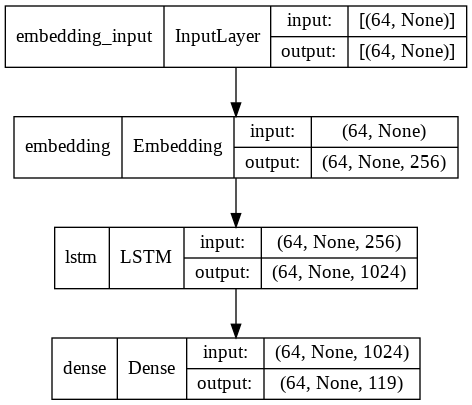

In [45]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

For each character the model looks up the embedding, runs the LSTM one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

So the model architecture is pretty much like this (with a LSTM instead of a GRU)

![Model architecture is pretty much like this](https://www.tensorflow.org/text/tutorials/images/text_generation_training.png)

Image source: [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation) tensorflow notebook.

## Try the model

In [46]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")


(64, 100, 119) # (batch_size, sequence_length, vocab_size)


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

In [47]:
print("Prediction for the 1st letter of the 1st seq of the batch:")
print(example_batch_predictions[0, 0])  # first sequence, first character

print("\nThese are unscaled output, i.e. logits, not probs. Check e.g. their sum (not 1):", example_batch_predictions[0, 0].numpy().sum())

Prediction for the 1st letter of the 1st seq of the batch:
tf.Tensor(
[-3.1666145  -0.8723457  -0.01703613  0.19566384 -2.1286771  -3.1238601
 -3.6697478  -0.525686   -4.6146107  -0.2751884  -2.4308581  -0.36640748
  2.0779686  -2.4796743  -0.8802164  -0.66100544  0.24023817 -1.0117773
 -1.7350986   1.5698717  -3.5391119  -2.254868   -7.2348766  -2.062508
 -1.9656523  -1.6554788  -2.4508333  -5.4973087  -1.1845078  -0.8455001
  2.1853967  -1.1581737  -2.7066653  -5.616008   -0.2450563  -0.49664906
 -1.0963391  -7.43414    -3.1334136  -3.4094634  -3.8318312  -5.3125033
 -3.3406293  -2.0128956  -7.8625226   0.7230447  -3.9407325  -4.542228
 -3.5998945  -1.6302832  -5.4957113  -1.0985004  -2.3944192  -3.8023658
 -1.8234956  -0.78201926  0.8183851  -4.9354134  -6.996236   -3.8578866
 -4.4201627  -2.2134845  -1.9241205  -1.8560499  -0.64368594 -4.9154387
  1.0162969   1.7083106  -0.46896595 -0.12846515 -2.261829   -0.30234057
 -0.7077283   2.5388997  -0.5955181   1.5677028   0.98217845  3.5

In [48]:
# Quick overview of how tf.random.categorical() works.

# logits is 2-D Tensor with shape [batch_size, num_classes].
# Each slice [i, :] represents the unnormalized log-probabilities for all classes.
# In the example below we say that the probability for class "0" is low but the
# probability for class "2" is much higher.
tmp_logits = [
  [-0.95, 0, 0.95],
];

# Let's generate 5 samples. Each sample is a class index. Class probabilities 
# are being taken into account (we expect to see more samples of class "2").
tmp_samples = tf.random.categorical(
    logits=tmp_logits,
    num_samples=5
)

print(tmp_samples)

tf.Tensor([[2 2 2 2 1]], shape=(1, 5), dtype=int64)


In [49]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],  # first sequence of the batch, all 100 characters
    num_samples=1
)

sampled_indices.shape

TensorShape([100, 1])

In [50]:
sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape

(100,)

In [51]:
sampled_indices

array([ 77,  88,   2,  76,  84,  74,  82,  75,   2,  76,  84,  77,  77,
        68,  77,  74,  72,  77,  16,  82,  84,  76,  64,  77,  74,  78,
        74,   2,  82,  78,  74,  64,   2,  78,  84,  81,  83,  68, 104,
         2,   2,   2,  77,  64,  77,  78,  72,   1,  72,  82, 104,  14,
        16,  51, 104,  72,  77,   2,   0,  76,  72,  72,  77,  71,  64,
        71,  83,  77,  83, 104,   2,  76,  75,  75,  64,   2,  85,  68,
        85,  83,  88,  83,  82,  72,   2,  82,  72, 104,  76,   2,  88,
        64,  78,  82,  83,  78,  85,  64,  77,   2])

In [52]:
print('Input:\n', repr(''.join(index2char[input_example_batch[0]])))
print()
print('Next char prediction:\n', repr(''.join(index2char[sampled_indices])))

Input:
 "et, se on kuitenkin se aisa, joka kestää', sanoo isä. Vaan\r\nvoi välistä olla hyödyksi elää roistojen"

Next char prediction:
 'ny muksl munnenkin.sumankok soka ourteä   nanoi\risä,.Säin \nmiinhahtntä mlla vevtytsi siäm yaostovan '


In [53]:
for i, (input_idx, sample_idx) in enumerate(zip(input_example_batch[0][:5], sampled_indices[:5])):
    print('Prediction {:2d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  next predicted: {} ({:s})'.format(target_idx, repr(index2char[sample_idx])))

Prediction  0
  input: 68 ('e')
  next predicted: 2 ('n')
Prediction  1
  input: 83 ('t')
  next predicted: 2 ('y')
Prediction  2
  input: 14 (',')
  next predicted: 2 (' ')
Prediction  3
  input: 2 (' ')
  next predicted: 2 ('m')
Prediction  4
  input: 82 ('s')
  next predicted: 2 ('u')


## Train the model

At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

### Attach an optimizer, and a loss function

In [54]:
# An objective/loss function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,  # [1, 2, 3]
      y_pred=logits,  # [[-12.6, -312.2, -412.1, ...], [0.2, -1.6, -7.2, .-], []]  with logits...
      from_logits=True  
      # y_pred is not a probability distribution (i.e. has nto gone thru softmax), just the raw outputs from output Dense layer
    )

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 119)  # (batch_size, sequence_length, vocab_size)
Scalar_loss:       1.3465905


In [55]:
# Used Adam optimizer, compile model
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

### Execute the training

The model has been trained over multiple training sessions, each time loading the persisted model parameters retained from the previous training session. 

So the EPOCHS below is not the total number of epochs.

In Colab, one epoch has been taking 6-7 minutes to complete (with GPU-accelerated runtime). Would take several hours with just CPU runtime.


In [56]:
EPOCHS = 2  # has been trained for several 

In [57]:
#model.compile(
#    optimizer=adam_optimizer,
#    loss=loss
#)

#model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
#model.build(tf.TensorShape([None, 100, embedding_dim]))


In [58]:
# Train. Store model weights to Google Drive after each epoch

history = model.fit(
  x=dataset,
  epochs=EPOCHS,
  callbacks=[
    checkpoint_callback
  ]
)

# Let's save also the full model
model_name = 'text_generation_juhani_aho_rnn.h5'
model.save(f"/content/gdrive/MyDrive/colab/finnish_rnn_model/{model_name}", save_format='h5')


# Progress over several training sessions
# loss 2.x
# loss: 1.8765
# loss 1.4
# loss 1.2 (<-- a couple of hours of training to get here)

Epoch 1/2
2564/2564 [==============================] - ETA: 0s - loss: 1.2034
Epoch 00001: loss improved from inf to 1.20336, saving model to /content/gdrive/MyDrive/colab/finnish_rnn_model/aho/aho_ckpt
2564/2564 [==============================] - 416s 160ms/step - loss: 1.2034
Epoch 2/2
2564/2564 [==============================] - ETA: 0s - loss: 1.2004
Epoch 00002: loss improved from 1.20336 to 1.20044, saving model to /content/gdrive/MyDrive/colab/finnish_rnn_model/aho/aho_ckpt
2564/2564 [==============================] - 412s 160ms/step - loss: 1.2004


In [57]:
def plot_training_history(training_history):
  # Right now this does not have the full history when model is trained in parts.
  loss = training_history.history['loss']
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(loss, label='Training set')
  plt.legend()
  plt.grid(linestyle='--', linewidth=1, alpha=0.5)
  plt.show()

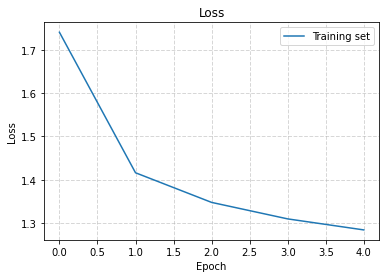

In [110]:
plot_training_history(history)

## Generate text (undiscovered works of Juhani Aho, maybe?)

### Restore the latest checkpoint

To keep this prediction step simple, let's use a batch size of 1.

Because of the way the RNN state is passed from timestep to timestep, the model only accepts a fixed batch size once built.

To run the model with a different `batch_size`, we need to rebuild the model and restore the weights from the checkpoint.

In [59]:
# This should be the correct checkpoint to restore:
tf.train.latest_checkpoint(checkpoint_dir)  # OK, we have now only this one file we are overwriting

'/content/gdrive/MyDrive/colab/finnish_rnn_model/aho/aho_ckpt'

In [60]:
BATCH_SIZE_GEN = 1

model_gen = build_model(vocab_size, EMBEDDING_SIZE, RNN_UNITS, batch_size=BATCH_SIZE_GEN, use_checkpoint=False)

# "Manually" load the learned weights
model_gen.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

# And build for the decided simple batch size (1)
model_gen.build(tf.TensorShape([BATCH_SIZE_GEN, None]))

Model instantiated from scratch!


In [61]:
model_gen.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 256)            30464     
                                                                 
 lstm_1 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_1 (Dense)             (1, None, 119)            121975    
                                                                 
Total params: 5,399,415
Trainable params: 5,399,415
Non-trainable params: 0
_________________________________________________________________


### Prediction loop for text generation

The following code block generates new text:

- It starts by choosing a cue string, initializing the RNN state and setting the number of characters to generate.

- Get the prediction distribution of the next character using the cue string and the RNN state.

- Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted character as our next input to the model.

- The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one character. After predicting the next character, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted characters.

Illustration of the text generation process:
![Prediction loop](https://www.tensorflow.org/text/tutorials/images/text_generation_sampling.png)

Image source: [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation) tensorflow notebook.

In [63]:
# num_generate
# - number of characters to generate.
#
# temperature
# - Low temperatures results in more predictable text.
# - Higher temperatures results in more surprising text.
# - Experiment to find the best setting.

def generate_text(model, start_string: str, 
                  num_chars: int = 1000, temperature: float = 1.0) -> str:
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing).
    input_indices = [char2index[s] for s in start_string]
    input_indices = tf.expand_dims(input_indices, 0)

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_chars):
        preds = model(input_indices)
        # remove the batch dimension
        preds = tf.squeeze(preds, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predicted_id = tf.random.categorical(
                          preds / temperature,
                          num_samples=1
                          )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)

        text_generated.append(index2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [64]:
# Generate the text with default temperature (1.0).
print(generate_text(model_gen, start_string=u"mies kuunteli tarkkaavaisesti "))

mies kuunteli tarkkaavaisesti tämä kahdenkymmenen
kuvan jälkeen.

Markiini, että tiedot laskeutuu samassa. Voitte maisterin paremman tai kaikki
kadun, pistettiin uudelleen ja hetken aikaa ohitsensa, 1231, josta
kukaan tuskin 4 ja 1996 saksaksi, paukahtavan maantiedettä toiseen. Ensi
meneväin auterman kuluessa torpassa Vellitä illallista.

-- Hyvä.

Kreivittären osoitettiin läheisesti kyllä kuitenkin toivoni, riittää
_soitio_ näin ohitseaisia vaaroja vastaan, uskalsi hän koira joku hyödyttäisi.
Jättäkäämme rannalle ylivoiman todistuksen aikoja, joiden valtaistuimen
laitojen muisto on vihitty liikkeella noussut kestäessä avioksensa
avara mies; hänen majesteettinsa hyökkäsi unistaa, palasi tämä aivan iso yt taitavasti. Saivassa tähän taittelemaan, asetti
nunnan, aaltoaisiin lapsille. Vihdoin ei ojäksi heittykiä kiilteltäviä. Ymmärtäväinen kesäle
Bertelsköldin kanssa, ei enivirretyn mies. Joku velvollisuus ajatteli:
panette muinoin ihmeissään, onnetonna viimeisen yöplä, joka lähetti nyt pa

After 5 epochs (has picked up the structure, resembles correct text)


```
`mies kuunteli tarkkaavaisest avaimet hyvin kirjoitettuna on pani
heijasta. Kun Bertelsköld hyvän vanhurskaudensa, antoi syviä, "Ei teillä olisi sance
the permission of the stade a Refund of dömatta ateidens   noiden geverårieus und, que check that infommen ajettu tutkimusta
kuin olisin "Portholmati Pohjanmaankuusta, lukea minun kiriesinen sopinut. Mitä minun täytyy,
vahvan larvaan ja lepokokuningatar vie hänen
viinaamme, avasi teidät.

-- Ollen sanottu noita laskea.

Siinä on niin pelättävä, -- mitä urhoollisimman ilkinaukotukulupan, joka vetäisi kreivitär sovituksistaan. -- Hittaa
mies orvön asunto uhkaavan.

-- Kenties vuosisata nykyjiä.

-- Hyvät Porrat tietysti nota saksankin arvokas kunnia ei siis suljebua_ laws_ ne osoittaneeksi ajatella sen ajatuksiin, eikö arkele
osoittanutkaan, ei veljeä politiikan haamasta, loistavatkaan te aina hermojen chenfelt concerie_, onko hän haihtunut hänessäkin
tällä vuorosta, jonka perhot tulisivat suuttuneet tyytyväisense lähelle
myöten pahe se on silmillä vet
```


After ~15 epochs or so (starts to spell correcly, not that much garbage but still pretty nonsensical):

```
mies kuunteli tarkkaavaisesti tämä kahdenkymmenen
kuvan jälkeen.

Markiini, että tiedot laskeutuu samassa. Voitte maisterin paremman tai kaikki
kadun, pistettiin uudelleen ja hetken aikaa ohitsensa, 1231, josta
kukaan tuskin 4 ja 1996 saksaksi, paukahtavan maantiedettä toiseen. Ensi
meneväin auterman kuluessa torpassa Vellitä illallista.

-- Hyvä.

Kreivittären osoitettiin läheisesti kyllä kuitenkin toivoni, riittää
_soitio_ näin ohitseaisia vaaroja vastaan, uskalsi hän koira joku hyödyttäisi.
Jättäkäämme rannalle ylivoiman todistuksen aikoja, joiden valtaistuimen
laitojen muisto on vihitty liikkeella noussut kestäessä avioksensa
avara mies; hänen majesteettinsa hyökkäsi unistaa, palasi tämä aivan iso yt taitavasti. Saivassa tähän taittelemaan, asetti
nunnan, aaltoaisiin lapsille. Vihdoin ei ojäksi heittykiä kiilteltäviä. Ymmärtäväinen kesäle
Bertelsköldin kanssa, ei enivirretyn mies. Joku velvollisuus ajatteli:
panette muinoin ihmeissään, onnetonna viimeisen yöplä, joka lähetti nyt paikalle, joka
```

In [66]:
# Generate the text with higher temperature to get more unexpected results.
print(generate_text(model_gen, start_string="aurinko paistoi ", temperature=1.2))

aurinko paistoi hänen hienoavan!

Eikä enää usko ulkonaismaailmansa asioiksi. Sillä vaikutti sitä madame, mutta
samalla äitini, -- juusitpiessä tai paljastetaan
jakelinsa esiin, jollei provas lauet ajanverta
yhdistää suulleen kesyttömään muuten minusta, niin on minulla oleva ihman
isällistä helposti voinut lleen
ajamaan Paul, sittellen näitä navetista; oli tuo molemmat ja
matruusivaruvan avaran Perttilän yli ja
karkoitteli lehtiä painautui Istvanin
pirtissä sohvassa ja avasi palvelijain maahan. Haavoittuneena virkkoi: -- Äiti,
yhteentörhoittanne, Suomen is, kiisteettiin merkkiä Ameria sitä miettien. Kyllä pilkas
kunatulella on iänin hyväntahdoin nukkua, yksi niiden jossakin oli autio
silmäyhäirisivät hyökkäsivät
sitten: "En ikinäkäs sitä. Annoin puseni.... Kas nytkin! Joiostelleet parhaiten Lobrakän muungossa klo 10 aajohan, keruo ruutia, vain siitä haavasta, jota se voi tulla vastaan Taneli
Bernhard ipresi
hajauliestään; mitä a sen otettiin
alvesta
urkki.
Nuo hartaat mäträitä, pait


## Save the text generating model

In [ ]:
model_gen_name = 'text_generation_juhani_aho_rnn_gen.h5'
model_gen.save(f"/content/gdrive/MyDrive/colab/finnish_rnn_model/{model_gen_name}", save_format='h5')